In [ ]:
# This notebook:

    # Loads the preprocessed time series data

    # Builds an LSTM model with PyTorch

    # Trains and evaluates the model

    # Saves the trained weights

    # Plots predictions

In [1]:
# 📦 Step 0: Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


In [2]:
# 📂 Step 1: Load the preprocessed dataset
df = pd.read_csv("../data/processed/etth1_processed.csv", parse_dates=["date"], index_col="date")

# We'll use 'OT' (outside temperature) for forecasting
target = df["OT"].values

In [3]:
# 🧩 Step 2: Create PyTorch Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size):
        self.window_size = window_size
        self.series = torch.tensor(series, dtype=torch.float32)

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        x = self.series[idx:idx + self.window_size]
        y = self.series[idx + self.window_size]
        return x.unsqueeze(1), y


In [4]:
# 📊 Step 3: Prepare DataLoader
window_size = 48  # predict next hour using past 48
batch_size = 32

dataset = TimeSeriesDataset(target, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
# 🧠 Step 4: Define LSTM Model
class LSTMForecast(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        return self.fc(output[:, -1, :])


In [6]:
# ⚙️ Step 5: Train the Model
model = LSTMForecast().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")


Epoch 1, Loss: 0.0047
Epoch 2, Loss: 0.0008
Epoch 3, Loss: 0.0006
Epoch 4, Loss: 0.0005
Epoch 5, Loss: 0.0004
Epoch 6, Loss: 0.0004
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0003


In [8]:
# 💾 Step 6: Save the trained model
torch.save(model.state_dict(), "../models/checkpoints/lstm_model.pt")
print("✅ Model saved to checkpoints/lstm_model.pt")


✅ Model saved to checkpoints/lstm_model.pt


C:\Users\BERAT\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


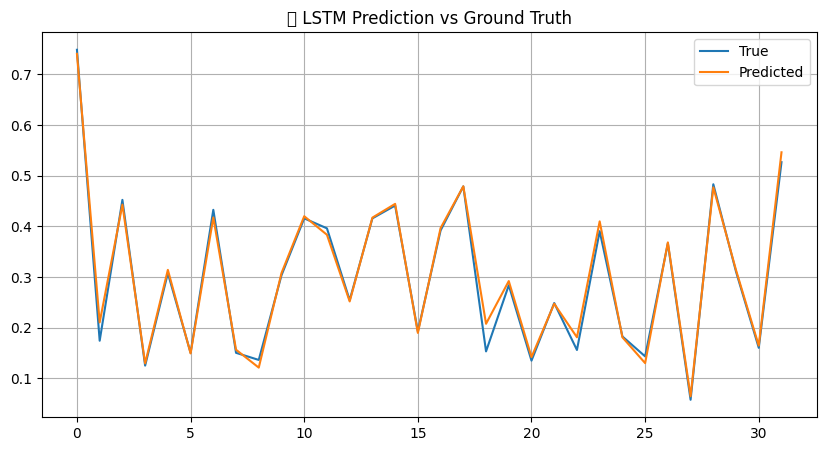

RMSE: 0.0148


In [9]:
# 📈 Step 7: Plot a few predictions
model.eval()
test_x, test_y = next(iter(dataloader))
test_x = test_x.to(device)
with torch.no_grad():
    pred_y = model(test_x).cpu().numpy()
    true_y = test_y.numpy()

plt.figure(figsize=(10, 5))
plt.plot(true_y[:50], label="True")
plt.plot(pred_y[:50], label="Predicted")
plt.legend()
plt.title("🔮 LSTM Prediction vs Ground Truth")
plt.grid(True)
plt.show()
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_y, pred_y))
print(f"RMSE: {rmse:.4f}")

In [10]:
# 📊 Step 8: Evaluate the model
predictions = []
true_values = []
for x, y in dataloader:
    x = x.to(device)
    with torch.no_grad():
        pred = model(x).cpu().numpy()
        predictions.append(pred)
        true_values.append(y.numpy())
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)
mse = mean_squared_error(true_values, predictions)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0003


C:\Users\BERAT\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


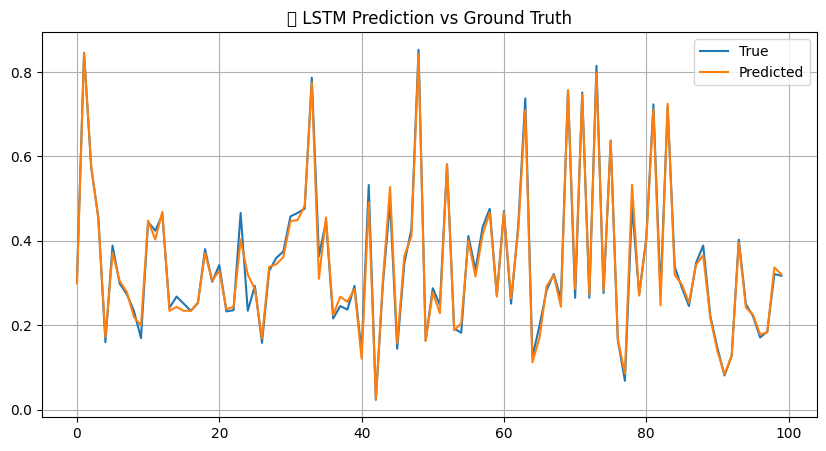

In [11]:
# 📊 Step 9: Plot the predictions vs true value
plt.figure(figsize=(10, 5))
plt.plot(true_values[:100], label="True")
plt.plot(predictions[:100], label="Predicted")
plt.legend()
plt.title("🔮 LSTM Prediction vs Ground Truth"
          )
plt.grid(True)
plt.show()